In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import time
import scipy.stats as st
import os 
from lfimodels.balancednetwork.BalancedNetwork import BalancedNetwork
from lfimodels.balancednetwork.BalancedNetworkStats import BalancedNetworkStats

In [2]:
m = BalancedNetwork(dim=1, first_port=8010, verbose=False, n_servers=3)

s = BalancedNetworkStats()

In [15]:
inference_method = 'snpe'
filename = '1502882580341386_snpe_r5_ntrain400'
time_str = filename[:filename.find('_')]
filename.find('_')
fullname = 'data/' + filename + '.p'

In [16]:
# load data 
with open(fullname, 'rb') as handle:
    result_dict = pickle.load(handle)

In [17]:
# unpack values 
true_params, stats_obs, nrounds, ntrain, posterior = result_dict.values()
mean, std = posterior.values()

## Compare to true parameter 

We have generated the observed data ourselves so we do have the true parameter. The mean of the posterior should be close to it when evaluated for $x=x_{obs}$

In [20]:
theta = np.linspace(2, 3, 1000)
post_pdf = st.norm.pdf(x=theta, loc=mean, scale=std)

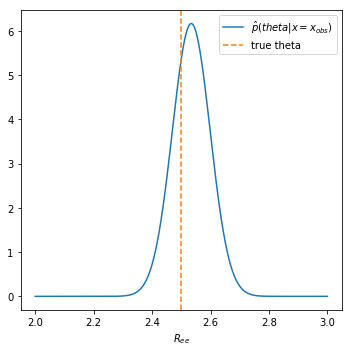

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(theta, post_pdf, label='$\hat{p}( theta | x=x_{obs})$')
plt.axvline(x=true_params[0], label='true theta', linestyle='--', color='C1')
plt.legend()
plt.xlabel('$R_{ee}$');
filename = time_str + '_{}_posterior_r{}_ntrain{}.pdf'.format(inference_method, nrounds, ntrain)
plt.tight_layout()
plt.savefig('figures/' + filename)

## Posterior predictive checking 

Generate samples from the posterior and simulate them. The resulting data should be near the observed data. 

In [22]:
m.start_server()
# generate theta +-3, 2, 1 0 stds away from mode
thetas = [mean + i * std for i in [-3, -2, -1, 0, 1, 2, 3]]
sum_stats = []
# simulate and collect sum stats
data = m.gen(thetas)

starting 2 / 7. total time remaining: ca. 60.0s 
starting 3 / 7. total time remaining: ca. 60.0s 
starting 1 / 7. total time remaining: ca. 90.0s 
starting 4 / 7. total time remaining: ca. 60.0s 
starting 5 / 7. total time remaining: ca. 30.0s 
starting 6 / 7. total time remaining: ca. 30.0s 
starting 7 / 7. total time remaining: ca. 30.0s 


In [23]:
for datum in data: 
    sum_stats.append(s.calc(datum))
m.stop_server()

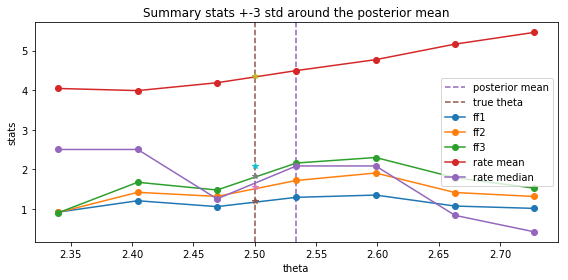

In [24]:
# plot the resulting stats with the observed stats 
plt.figure(figsize=(8, 4))
sum_stats = np.array(sum_stats).squeeze()
plt.axvline(x=mean, linestyle='--', color='C4')
plt.axvline(x=true_params, linestyle='--', color='C5')
plt.plot(thetas, sum_stats, '-o')
plt.plot(true_params, stats_obs, '*')
plt.legend(['posterior mean', 'true theta', 'ff1', 'ff2', 'ff3', 'rate mean', 'rate median'])
plt.xlabel('theta')
plt.ylabel('stats')
plt.title('Summary stats +-3 std around the posterior mean')
filename = '{}_ppch_r{}_ntrain{}.pdf'.format(inference_method, nrounds, ntrain)
plt.tight_layout()
plt.savefig('figures/' + filename)